In [4]:
!git clone https://github.com/IvanWoelffel/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 734 (delta 1), reused 4 (delta 1), pack-reused 725 (from 2)
Receiving objects: 100% (734/734), 6.03 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (394/394), done.


In [5]:
!ls

AGENTS.md	 LICENSE	     test_rope_comparison.ipynb
assets		 model.py	     test_wikitext2_bookcorpus.ipynb
bench.py	 nanoGPT	     train.py
config		 README.md	     transformer_sizing.ipynb
configurator.py  sample.py	     wikitext2_vs_bookcorpus_comparison.png
data		 scaling_laws.ipynb
doc		 test.ipynb


In [6]:
%cd nanoGPT

/content/nanoGPT/nanoGPT


# Nano-GPT: RoPE vs Standard Position Embeddings Comparison

This notebook compares Rotary Position Embeddings (RoPE) against standard absolute positional embeddings on two datasets:
- **WikiText-2**: Encyclopedic text from Wikipedia
- **BookCorpus**: Narrative text from books (sampled subset)

**Objectives:**
1. Compare RoPE vs standard position embeddings on WikiText-2
2. Compare RoPE vs standard position embeddings on BookCorpus
3. Analyze if RoPE effect is similar across different text styles
4. Study convergence speed and final perplexities
5. Compare text generation quality

In [7]:
import torch
import torch.nn as nn
import numpy as np
from model import GPT, GPTConfig
import tiktoken
from contextlib import nullcontext
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from tqdm.auto import tqdm

torch.manual_seed(1337)
np.random.seed(1337)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete. Libraries imported.")

Setup complete. Libraries imported.


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16'

batch_size = 12
block_size = 256
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.1
learning_rate = 1e-3
max_iters = 3000
eval_interval = 200
eval_iters = 100
warmup_iters = 100
min_lr = 1e-4
weight_decay = 0.1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0
decay_lr = True
rope_theta = 10000.0
TARGET_TOKENS = 2_500_000

print(f"Device: {device}, Dtype: {dtype}")
print(f"Model: {n_layer} layers, {n_head} heads, {n_embd} dim")
print(f"Training: {max_iters} iters, batch_size={batch_size}, block_size={block_size}")
print(f"RoPE theta: {rope_theta}")
print(f"BookCorpus target: {TARGET_TOKENS:,} tokens")

Device: cuda, Dtype: bfloat16
Model: 6 layers, 6 heads, 384 dim
Training: 3000 iters, batch_size=12, block_size=256
RoPE theta: 10000.0
BookCorpus target: 2,500,000 tokens


In [9]:
def prepare_wikitext2():
    train_path = 'data/wikitext2/train.bin'
    val_path = 'data/wikitext2/val.bin'

    if os.path.exists(train_path) and os.path.exists(val_path):
        print("WikiText-2 already prepared")
        return

    print("Preparing WikiText-2 dataset...")
    from datasets import load_dataset

    enc = tiktoken.get_encoding("gpt2")
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

    for split, split_name in [('train', 'train'), ('validation', 'val')]:
        all_ids = []
        for example in tqdm(dataset[split], desc=f"Tokenizing {split}"):
            if example['text'].strip():
                ids = enc.encode_ordinary(example['text'])
                ids.append(enc.eot_token)
                all_ids.extend(ids)

        arr = np.array(all_ids, dtype=np.uint16)
        os.makedirs('data/wikitext2', exist_ok=True)
        arr.tofile(f'data/wikitext2/{split_name}.bin')
        print(f"  {split_name}: {len(arr):,} tokens ({len(arr)*2/1024/1024:.2f} MB)")

    print("WikiText-2 preparation complete")


def prepare_bookcorpus_sample(target_tokens=TARGET_TOKENS):
    train_path = 'data/bookcorpus/train_sample.bin'
    val_path = 'data/bookcorpus/val_sample.bin'

    if os.path.exists(train_path) and os.path.exists(val_path):
        train_data = np.memmap(train_path, dtype=np.uint16, mode='r')
        if len(train_data) >= target_tokens * 0.9:
            print(f"BookCorpus sample already prepared ({len(train_data):,} tokens)")
            return

    print(f"Preparing BookCorpus sample (target ~{target_tokens:,} tokens)...")
    from datasets import load_dataset

    enc = tiktoken.get_encoding("gpt2")
    val_ratio = 0.1

    dataset = load_dataset("SamuelYang/bookcorpus", split="train", streaming=True)

    train_ids = []
    val_ids = []

    for i, example in enumerate(tqdm(dataset, desc="Tokenizing BookCorpus")):
        if len(train_ids) >= target_tokens:
            break

        text = example['text']
        if text.strip():
            ids = enc.encode_ordinary(text)
            ids.append(enc.eot_token)

            if np.random.random() < val_ratio:
                val_ids.extend(ids)
            else:
                train_ids.extend(ids)

    os.makedirs('data/bookcorpus', exist_ok=True)

    train_arr = np.array(train_ids[:target_tokens], dtype=np.uint16)
    train_arr.tofile(train_path)
    print(f"  train_sample: {len(train_arr):,} tokens ({len(train_arr)*2/1024/1024:.2f} MB)")

    val_arr = np.array(val_ids[:int(target_tokens*val_ratio)], dtype=np.uint16)
    val_arr.tofile(val_path)
    print(f"  val_sample: {len(val_arr):,} tokens ({len(val_arr)*2/1024/1024:.2f} MB)")

    print("BookCorpus sample preparation complete")

print("Dataset preparation functions defined!")

Dataset preparation functions defined!


In [10]:
print("Preparing datasets...")
prepare_wikitext2()
prepare_bookcorpus_sample()

print("\nLoading datasets...")

wikitext2_train = np.memmap('data/wikitext2/train.bin', dtype=np.uint16, mode='r')
wikitext2_val = np.memmap('data/wikitext2/val.bin', dtype=np.uint16, mode='r')

bookcorpus_train = np.memmap('data/bookcorpus/train_sample.bin', dtype=np.uint16, mode='r')
bookcorpus_val = np.memmap('data/bookcorpus/val_sample.bin', dtype=np.uint16, mode='r')

print(f"\n{'='*60}")
print("DATASET STATISTICS")
print(f"{'='*60}")

print(f"\nWikiText-2 (Encyclopedic):")
print(f"  Train: {len(wikitext2_train):,} tokens ({len(wikitext2_train)*2/1024/1024:.2f} MB)")
print(f"  Val:   {len(wikitext2_val):,} tokens ({len(wikitext2_val)*2/1024/1024:.2f} MB)")

print(f"\nBookCorpus (Narrative - Sampled):")
print(f"  Train: {len(bookcorpus_train):,} tokens ({len(bookcorpus_train)*2/1024/1024:.2f} MB)")
print(f"  Val:   {len(bookcorpus_val):,} tokens ({len(bookcorpus_val)*2/1024/1024:.2f} MB)")

print(f"\nComparison:")
print(f"  WikiText-2 / BookCorpus ratio: {len(wikitext2_train)/len(bookcorpus_train):.2f}x")
print(f"  Difference: {abs(len(wikitext2_train) - len(bookcorpus_train)):,} tokens")

print(f"\n{'='*60}")
print("Datasets loaded successfully!")
print(f"{'='*60}")

Preparing datasets...
Preparing WikiText-2 dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing train:   0%|          | 0/36718 [00:00<?, ?it/s]

  train: 2,415,651 tokens (4.61 MB)


Tokenizing validation:   0%|          | 0/3760 [00:00<?, ?it/s]

  val: 249,750 tokens (0.48 MB)
WikiText-2 preparation complete
Preparing BookCorpus sample (target ~2,500,000 tokens)...


Tokenizing BookCorpus: 0it [00:00, ?it/s]

  train_sample: 2,500,000 tokens (4.77 MB)
  val_sample: 250,000 tokens (0.48 MB)
BookCorpus sample preparation complete

Loading datasets...

DATASET STATISTICS

WikiText-2 (Encyclopedic):
  Train: 2,415,651 tokens (4.61 MB)
  Val:   249,750 tokens (0.48 MB)

BookCorpus (Narrative - Sampled):
  Train: 2,500,000 tokens (4.77 MB)
  Val:   250,000 tokens (0.48 MB)

Comparison:
  WikiText-2 / BookCorpus ratio: 0.97x
  Difference: 84,349 tokens

Datasets loaded successfully!


In [11]:
def create_model(vocab_size=50257, use_rope=False, rope_theta=10000.0):
    config = GPTConfig(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=n_layer,
        n_head=n_head,
        n_embd=n_embd,
        dropout=dropout,
        bias=True,
        use_rope=use_rope,
        rope_theta=rope_theta,
    )
    return GPT(config)

print("Creating models...")

model_wikitext_no_rope = create_model(use_rope=False)
model_wikitext_rope = create_model(use_rope=True)
model_bookcorpus_no_rope = create_model(use_rope=False)
model_bookcorpus_rope = create_model(use_rope=True)

models = {
    'wikitext_no_rope': (model_wikitext_no_rope, wikitext2_train, wikitext2_val, 'WikiText-2 (No RoPE)', 'out-wikitext2-no-rope'),
    'wikitext_rope': (model_wikitext_rope, wikitext2_train, wikitext2_val, 'WikiText-2 (RoPE)', 'out-wikitext2-rope'),
    'bookcorpus_no_rope': (model_bookcorpus_no_rope, bookcorpus_train, bookcorpus_val, 'BookCorpus (No RoPE)', 'out-bookcorpus-no-rope'),
    'bookcorpus_rope': (model_bookcorpus_rope, bookcorpus_train, bookcorpus_val, 'BookCorpus (RoPE)', 'out-bookcorpus-rope'),
}

num_params = model_wikitext_no_rope.get_num_params()

print(f"\n  All models: {num_params/1e6:.2f}M parameters")
print(f"  Architecture: {n_layer} layers, {n_head} heads, {n_embd} dimensions")
print(f"\n  Models created:")
for name, (_, _, _, display_name, _) in models.items():
    print(f"    - {display_name}")

print("\n" + "="*70)
print("Models created successfully!")
print("="*70)

Creating models...
number of parameters: 29.95M
number of parameters: 29.95M
number of parameters: 29.95M
number of parameters: 29.95M

  All models: 29.95M parameters
  Architecture: 6 layers, 6 heads, 384 dimensions

  Models created:
    - WikiText-2 (No RoPE)
    - WikiText-2 (RoPE)
    - BookCorpus (No RoPE)
    - BookCorpus (RoPE)

Models created successfully!


In [12]:
def get_batch(data, batch_size, block_size, device):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model, train_data, val_data, batch_size, block_size, eval_iters, device, dtype_ctx):
    model.eval()
    losses = {}

    for split, data in [('train', train_data), ('val', val_data)]:
        loss_list = []
        for _ in range(eval_iters):
            X, Y = get_batch(data, batch_size, block_size, device)
            with dtype_ctx:
                _, loss = model(X, Y)
            loss_list.append(loss.item())
        losses[split] = np.mean(loss_list)

    model.train()
    return losses

def get_lr(iter_num, warmup_iters, lr_decay_iters, learning_rate, min_lr):
    if iter_num < warmup_iters:
        return learning_rate * (iter_num + 1) / (warmup_iters + 1)
    if iter_num > lr_decay_iters:
        return min_lr
    decay_ratio = (iter_num - warmup_iters) / (lr_decay_iters - warmup_iters)
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

def train_model(model, train_data, val_data, max_iters, learning_rate, out_dir, dataset_name):
    model = model.to(device)
    model.train()

    optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device)
    scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

    dtype_torch = torch.bfloat16 if 'bfloat' in dtype else torch.float16
    if device == 'cuda':
        dtype_ctx = torch.amp.autocast(device_type=device, dtype=dtype_torch)
    else:
        dtype_ctx = nullcontext()

    history = {'train_loss': [], 'val_loss': [], 'lr': [], 'iter': [], 'time': []}
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"Training on {dataset_name}")
    print(f"{'='*60}")
    print(f"  Max iterations: {max_iters}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Parameters: {model.get_num_params()/1e6:.2f}M")
    print(f"  Train tokens: {len(train_data):,}")
    print(f"{'='*60}")

    t0 = time.time()
    best_val_loss = float('inf')

    for iter_num in range(max_iters):
        lr = get_lr(iter_num, warmup_iters, max_iters, learning_rate, min_lr) if decay_lr else learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        X, Y = get_batch(train_data, batch_size, block_size, device)

        with dtype_ctx:
            _, loss = model(X, Y)

        scaler.scale(loss).backward()
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if iter_num % eval_interval == 0 or iter_num == max_iters - 1:
            t1 = time.time()
            losses = estimate_loss(model, train_data, val_data, batch_size, block_size, eval_iters, device, dtype_ctx)
            dt = t1 - t0
            tokens_per_sec = batch_size * block_size * eval_interval / dt if dt > 0 else 0

            print(f"  Iter {iter_num:4d}/{max_iters}: train={losses['train']:.4f}, val={losses['val']:.4f}, lr={lr:.6f}, {tokens_per_sec:.0f} tok/s")

            history['train_loss'].append(losses['train'])
            history['val_loss'].append(losses['val'])
            history['lr'].append(lr)
            history['iter'].append(iter_num)
            history['time'].append(time.time() - t0)

            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                checkpoint = {
                    'model': model.state_dict(),
                    'config': model.config,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                }
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

            t0 = time.time()

    total_time = sum(history['time'])
    print(f"\n  Training completed in {total_time/60:.1f} minutes")
    print(f"  Best validation loss: {best_val_loss:.4f}")
    print(f"  Best validation perplexity: {np.exp(best_val_loss):.2f}")

    return history

print("Training functions defined!")

Training functions defined!


## Training All 4 Models

This cell trains all 4 model configurations sequentially:
1. WikiText-2 without RoPE
2. WikiText-2 with RoPE
3. BookCorpus without RoPE
4. BookCorpus with RoPE

In [13]:
histories = {}

print("="*70)
print("STARTING TRAINING OF ALL 4 MODELS")
print("="*70)
print(f"\nModels to train:")
for i, (name, (_, _, _, display_name, _)) in enumerate(models.items(), 1):
    print(f"  {i}. {display_name}")
print(f"\nTotal iterations per model: {max_iters}")
print(f"Estimated time: ~3-5 hours on GPU")
print("="*70)

training_start = time.time()

for model_name, (model, train_data, val_data, display_name, out_dir) in models.items():
    print(f"\n{'#'*70}")
    print(f"# TRAINING MODEL: {display_name.upper()}")
    print(f"{'#'*70}")

    history = train_model(
        model=model,
        train_data=train_data,
        val_data=val_data,
        max_iters=max_iters,
        learning_rate=learning_rate,
        out_dir=out_dir,
        dataset_name=display_name
    )

    histories[model_name] = history

    # Clear CUDA cache between models
    if device == 'cuda':
        torch.cuda.empty_cache()

total_training_time = time.time() - training_start

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*70)
print(f"Total training time: {total_training_time/3600:.2f} hours")

STARTING TRAINING OF ALL 4 MODELS

Models to train:
  1. WikiText-2 (No RoPE)
  2. WikiText-2 (RoPE)
  3. BookCorpus (No RoPE)
  4. BookCorpus (RoPE)

Total iterations per model: 3000
Estimated time: ~3-5 hours on GPU

######################################################################
# TRAINING MODEL: WIKITEXT-2 (NO ROPE)
######################################################################
num decayed parameter tensors: 26, with 30,013,824 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Training on WikiText-2 (No RoPE)
  Max iterations: 3000
  Learning rate: 0.001
  Parameters: 29.95M
  Train tokens: 2,415,651


/tmp/ipython-input-2314439750.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


  Iter    0/3000: train=10.8351, val=10.8332, lr=0.000010, 602088 tok/s
  Iter  200/3000: train=6.2696, val=6.4086, lr=0.000997, 12250 tok/s
  Iter  400/3000: train=5.8583, val=6.0915, lr=0.000976, 11461 tok/s
  Iter  600/3000: train=5.6098, val=5.9506, lr=0.000936, 11413 tok/s
  Iter  800/3000: train=5.4090, val=5.8358, lr=0.000877, 11371 tok/s
  Iter 1000/3000: train=5.1809, val=5.7308, lr=0.000803, 11379 tok/s
  Iter 1200/3000: train=5.0148, val=5.6212, lr=0.000717, 11366 tok/s
  Iter 1400/3000: train=4.8790, val=5.5844, lr=0.000623, 11366 tok/s
  Iter 1600/3000: train=4.7559, val=5.4931, lr=0.000526, 11361 tok/s
  Iter 1800/3000: train=4.6485, val=5.4286, lr=0.000430, 11362 tok/s
  Iter 2000/3000: train=4.4921, val=5.3807, lr=0.000339, 11357 tok/s
  Iter 2200/3000: train=4.4486, val=5.3353, lr=0.000259, 11330 tok/s
  Iter 2400/3000: train=4.3675, val=5.2370, lr=0.000192, 11368 tok/s
  Iter 2600/3000: train=4.3416, val=5.2366, lr=0.000142, 11382 tok/s
  Iter 2800/3000: train=4.2821,

## Final Evaluation and Results Extraction

In [14]:
# Extract final results from all models
results = {}

for model_name, history in histories.items():
    results[model_name] = {
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'train_ppl': np.exp(history['train_loss'][-1]),
        'val_ppl': np.exp(history['val_loss'][-1]),
        'best_val_loss': min(history['val_loss']),
        'best_val_ppl': np.exp(min(history['val_loss'])),
        'total_time': history['time'][-1] if history['time'] else 0,
    }

# Display results table
print("="*90)
print("FINAL RESULTS SUMMARY")
print("="*90)
print(f"{'Model':<30} {'Train Loss':>12} {'Val Loss':>12} {'Train PPL':>12} {'Val PPL':>12}")
print("-"*90)

display_names = {
    'wikitext_no_rope': 'WikiText-2 (No RoPE)',
    'wikitext_rope': 'WikiText-2 (RoPE)',
    'bookcorpus_no_rope': 'BookCorpus (No RoPE)',
    'bookcorpus_rope': 'BookCorpus (RoPE)',
}

for model_name, res in results.items():
    print(f"{display_names[model_name]:<30} {res['train_loss']:>12.4f} {res['val_loss']:>12.4f} {res['train_ppl']:>12.2f} {res['val_ppl']:>12.2f}")

print("="*90)

# Calculate improvements
print("\n" + "="*70)
print("ROPE IMPROVEMENT ANALYSIS")
print("="*70)

# WikiText-2 improvement
wiki_val_improvement = (results['wikitext_no_rope']['val_ppl'] - results['wikitext_rope']['val_ppl']) / results['wikitext_no_rope']['val_ppl'] * 100
wiki_train_improvement = (results['wikitext_no_rope']['train_ppl'] - results['wikitext_rope']['train_ppl']) / results['wikitext_no_rope']['train_ppl'] * 100

print(f"\nWikiText-2:")
print(f"  Without RoPE - Val PPL: {results['wikitext_no_rope']['val_ppl']:.2f}")
print(f"  With RoPE    - Val PPL: {results['wikitext_rope']['val_ppl']:.2f}")
print(f"  Improvement: {wiki_val_improvement:+.2f}% (positive = RoPE better)")

# BookCorpus improvement
book_val_improvement = (results['bookcorpus_no_rope']['val_ppl'] - results['bookcorpus_rope']['val_ppl']) / results['bookcorpus_no_rope']['val_ppl'] * 100
book_train_improvement = (results['bookcorpus_no_rope']['train_ppl'] - results['bookcorpus_rope']['train_ppl']) / results['bookcorpus_no_rope']['train_ppl'] * 100

print(f"\nBookCorpus:")
print(f"  Without RoPE - Val PPL: {results['bookcorpus_no_rope']['val_ppl']:.2f}")
print(f"  With RoPE    - Val PPL: {results['bookcorpus_rope']['val_ppl']:.2f}")
print(f"  Improvement: {book_val_improvement:+.2f}% (positive = RoPE better)")

print("\n" + "="*70)

FINAL RESULTS SUMMARY
Model                            Train Loss     Val Loss    Train PPL      Val PPL
------------------------------------------------------------------------------------------
WikiText-2 (No RoPE)                 4.2561       5.2375        70.53       188.20
WikiText-2 (RoPE)                    3.9705       5.0195        53.01       151.34
BookCorpus (No RoPE)                 4.0644       4.4143        58.23        82.62
BookCorpus (RoPE)                    3.7782       4.2381        43.74        69.28

ROPE IMPROVEMENT ANALYSIS

WikiText-2:
  Without RoPE - Val PPL: 188.20
  With RoPE    - Val PPL: 151.34
  Improvement: +19.58% (positive = RoPE better)

BookCorpus:
  Without RoPE - Val PPL: 82.62
  With RoPE    - Val PPL: 69.28
  Improvement: +16.15% (positive = RoPE better)



## Visualizations

### Figure 1: Training Loss Curves

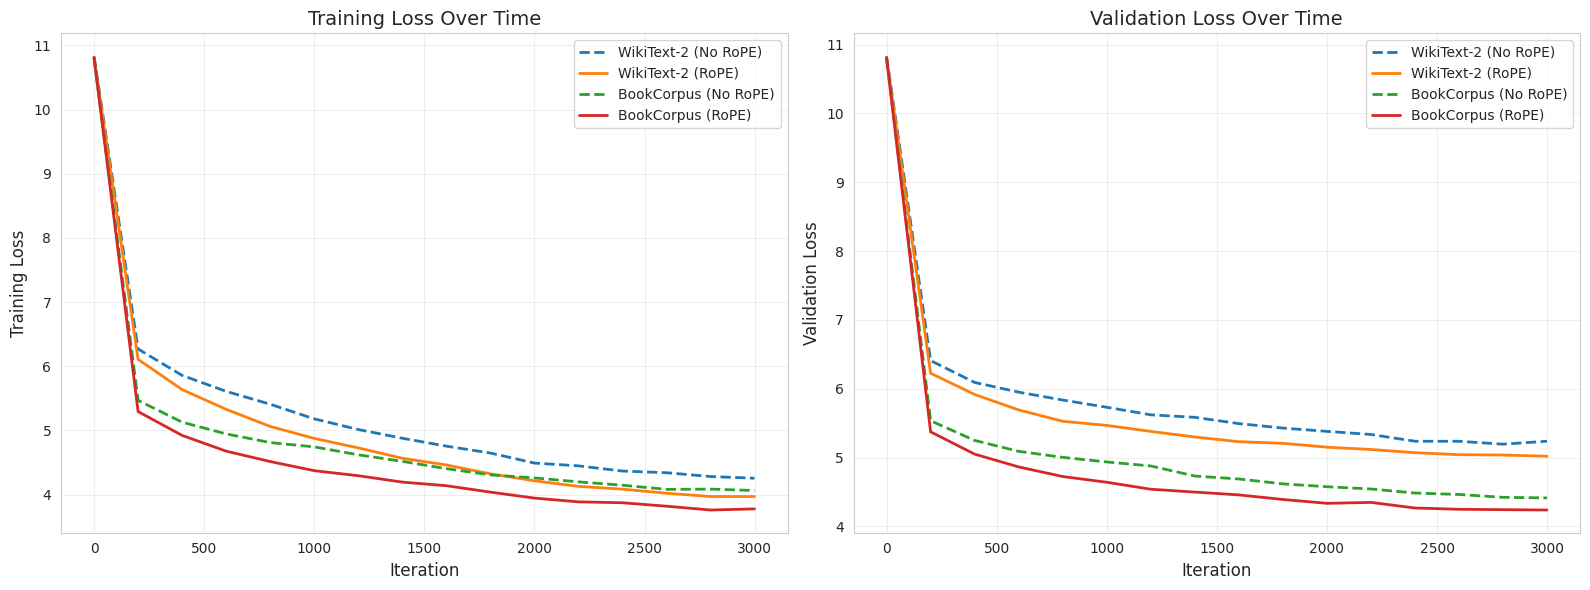

Figure saved: rope_comparison_loss.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors and styles
colors = {
    'wikitext_no_rope': '#1f77b4',
    'wikitext_rope': '#ff7f0e',
    'bookcorpus_no_rope': '#2ca02c',
    'bookcorpus_rope': '#d62728',
}

linestyles = {
    'wikitext_no_rope': '--',
    'wikitext_rope': '-',
    'bookcorpus_no_rope': '--',
    'bookcorpus_rope': '-',
}

# Plot 1: Training Loss
ax1 = axes[0]
for model_name, history in histories.items():
    ax1.plot(history['iter'], history['train_loss'],
             label=display_names[model_name],
             color=colors[model_name],
             linestyle=linestyles[model_name],
             linewidth=2)

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Over Time', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax2 = axes[1]
for model_name, history in histories.items():
    ax2.plot(history['iter'], history['val_loss'],
             label=display_names[model_name],
             color=colors[model_name],
             linestyle=linestyles[model_name],
             linewidth=2)

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Validation Loss Over Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rope_comparison_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: rope_comparison_loss.png")

### Figure 2: Perplexity Over Time

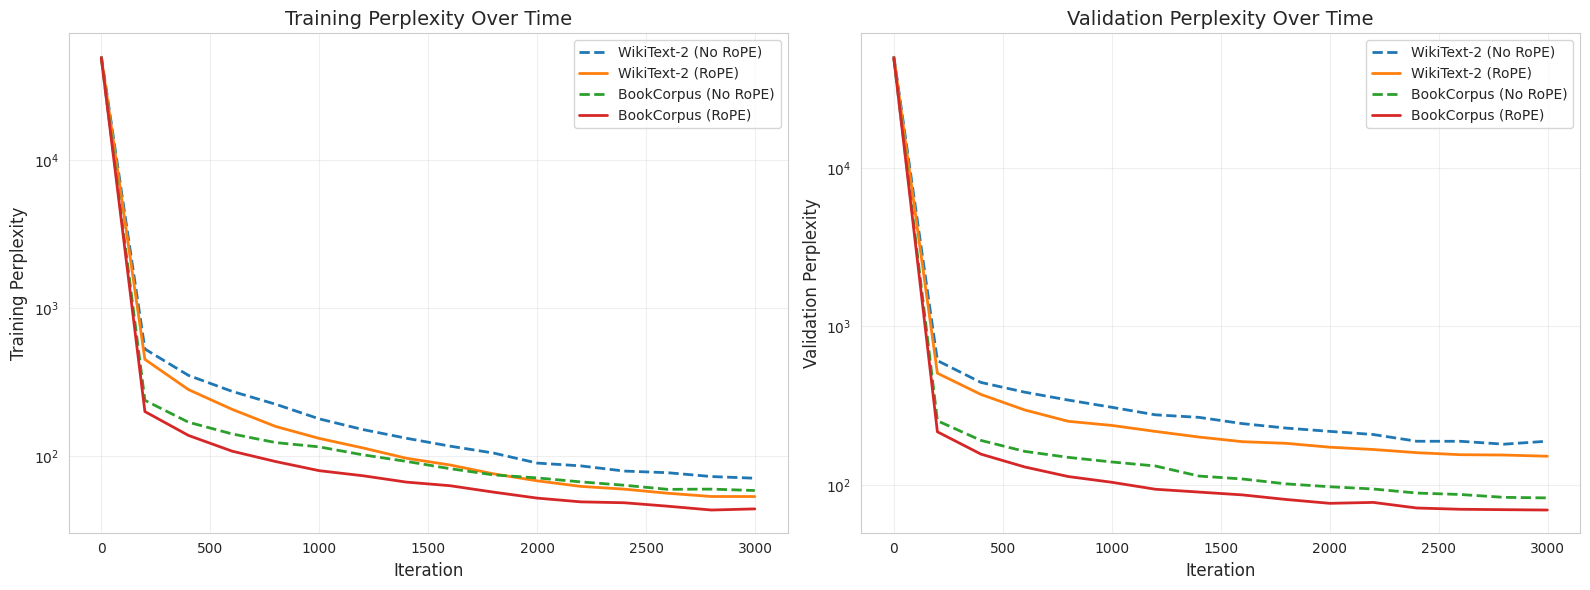

Figure saved: rope_comparison_perplexity.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training Perplexity
ax1 = axes[0]
for model_name, history in histories.items():
    ppl = [np.exp(l) for l in history['train_loss']]
    ax1.plot(history['iter'], ppl,
             label=display_names[model_name],
             color=colors[model_name],
             linestyle=linestyles[model_name],
             linewidth=2)

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Training Perplexity', fontsize=12)
ax1.set_title('Training Perplexity Over Time', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Validation Perplexity
ax2 = axes[1]
for model_name, history in histories.items():
    ppl = [np.exp(l) for l in history['val_loss']]
    ax2.plot(history['iter'], ppl,
             label=display_names[model_name],
             color=colors[model_name],
             linestyle=linestyles[model_name],
             linewidth=2)

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Validation Perplexity', fontsize=12)
ax2.set_title('Validation Perplexity Over Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('rope_comparison_perplexity.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: rope_comparison_perplexity.png")

### Figure 3: Final Results Comparison (Bar Charts)

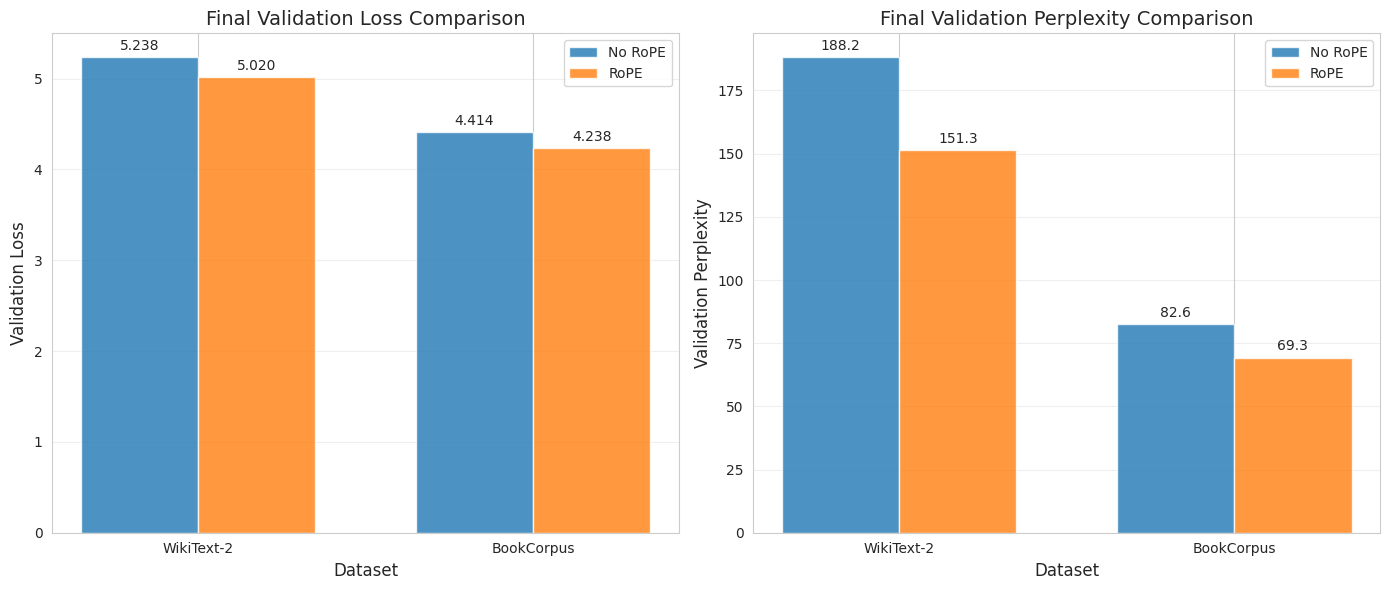

Figure saved: rope_comparison_final.png


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar positions
x = np.arange(2)  # WikiText-2, BookCorpus
width = 0.35

# Data for plotting
datasets = ['WikiText-2', 'BookCorpus']
no_rope_val_ppl = [results['wikitext_no_rope']['val_ppl'], results['bookcorpus_no_rope']['val_ppl']]
rope_val_ppl = [results['wikitext_rope']['val_ppl'], results['bookcorpus_rope']['val_ppl']]
no_rope_val_loss = [results['wikitext_no_rope']['val_loss'], results['bookcorpus_no_rope']['val_loss']]
rope_val_loss = [results['wikitext_rope']['val_loss'], results['bookcorpus_rope']['val_loss']]

# Plot 1: Validation Loss Comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, no_rope_val_loss, width, label='No RoPE', color='#1f77b4', alpha=0.8)
bars2 = ax1.bar(x + width/2, rope_val_loss, width, label='RoPE', color='#ff7f0e', alpha=0.8)

ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.set_title('Final Validation Loss Comparison', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Plot 2: Validation Perplexity Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, no_rope_val_ppl, width, label='No RoPE', color='#1f77b4', alpha=0.8)
bars4 = ax2.bar(x + width/2, rope_val_ppl, width, label='RoPE', color='#ff7f0e', alpha=0.8)

ax2.set_xlabel('Dataset', fontsize=12)
ax2.set_ylabel('Validation Perplexity', fontsize=12)
ax2.set_title('Final Validation Perplexity Comparison', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(datasets)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars4:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('rope_comparison_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: rope_comparison_final.png")

### Figure 4: Convergence Analysis

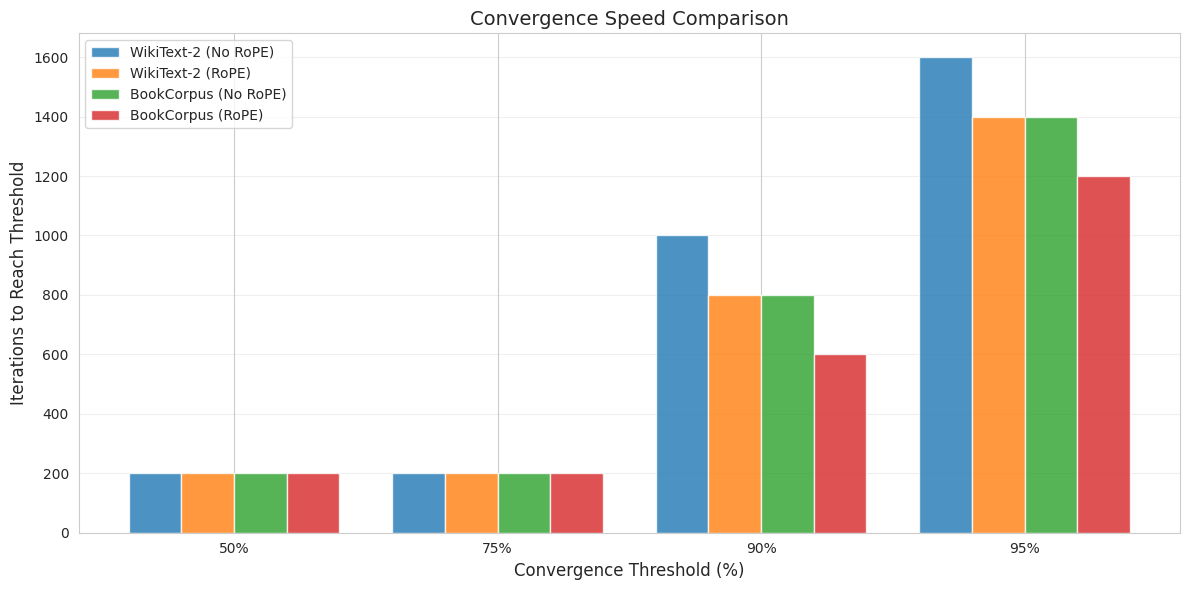

Figure saved: rope_comparison_convergence.png

CONVERGENCE SPEED (iterations to reach X% of final improvement)
Model                                 50%        75%        90%        95%
--------------------------------------------------------------------------------
WikiText-2 (No RoPE)                  200        200       1000       1600
WikiText-2 (RoPE)                     200        200        800       1400
BookCorpus (No RoPE)                  200        200        800       1400
BookCorpus (RoPE)                     200        200        600       1200


In [18]:
def find_convergence_iter(history, threshold_pct):
    """Find the iteration at which the model reaches threshold_pct of its final loss."""
    final_loss = history['val_loss'][-1]
    initial_loss = history['val_loss'][0]
    target_loss = initial_loss - (initial_loss - final_loss) * threshold_pct / 100

    for i, (iter_num, loss) in enumerate(zip(history['iter'], history['val_loss'])):
        if loss <= target_loss:
            return iter_num
    return history['iter'][-1]

# Calculate convergence iterations
convergence_data = {}
thresholds = [50, 75, 90, 95]

for model_name, history in histories.items():
    convergence_data[model_name] = {}
    for threshold in thresholds:
        convergence_data[model_name][threshold] = find_convergence_iter(history, threshold)

# Plot convergence comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(thresholds))
width = 0.2

model_names = list(histories.keys())
for i, model_name in enumerate(model_names):
    values = [convergence_data[model_name][t] for t in thresholds]
    ax.bar(x + i*width - 1.5*width, values, width,
           label=display_names[model_name],
           color=colors[model_name],
           alpha=0.8)

ax.set_xlabel('Convergence Threshold (%)', fontsize=12)
ax.set_ylabel('Iterations to Reach Threshold', fontsize=12)
ax.set_title('Convergence Speed Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'{t}%' for t in thresholds])
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rope_comparison_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: rope_comparison_convergence.png")

# Print convergence table
print("\n" + "="*80)
print("CONVERGENCE SPEED (iterations to reach X% of final improvement)")
print("="*80)
print(f"{'Model':<30} {'50%':>10} {'75%':>10} {'90%':>10} {'95%':>10}")
print("-"*80)
for model_name in model_names:
    values = [convergence_data[model_name][t] for t in thresholds]
    print(f"{display_names[model_name]:<30} {values[0]:>10} {values[1]:>10} {values[2]:>10} {values[3]:>10}")
print("="*80)

## Text Generation Comparison

Generate text samples from all 4 models to qualitatively compare their outputs.

In [19]:
enc = tiktoken.get_encoding("gpt2")

@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=100, temperature=0.8, top_k=40):
    model.eval()
    model = model.to(device)

    tokens = enc.encode(prompt)
    x = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

    dtype_torch = torch.bfloat16 if 'bfloat' in dtype else torch.float16
    if device == 'cuda':
        dtype_ctx = torch.amp.autocast(device_type=device, dtype=dtype_torch)
    else:
        dtype_ctx = nullcontext()

    with dtype_ctx:
        generated = model.generate(x, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k)

    return enc.decode(generated[0].tolist())

# Test prompts
prompts = [
    "The history of artificial intelligence",
    "Once upon a time, in a distant land,",
    "The most important scientific discovery",
]

print("="*80)
print("TEXT GENERATION COMPARISON")
print("="*80)

for prompt in prompts:
    print(f"\n{'='*80}")
    print(f"PROMPT: \"{prompt}\"")
    print("="*80)

    for model_name, (model, _, _, display_name, _) in models.items():
        print(f"\n--- {display_name} ---")
        try:
            generated = generate_text(model, prompt, max_new_tokens=80)
            print(generated)
        except Exception as e:
            print(f"Error generating text: {e}")

    print()

TEXT GENERATION COMPARISON

PROMPT: "The history of artificial intelligence"

--- WikiText-2 (No RoPE) ---
The history of artificial intelligence is not necessary to be given to the " dramatic power to the " . 
<|endoftext|> The work of the game became a " typical " , and was given to the " and " an anti @-@ aircraft " . It was released in May 2006 , as of the first three @-@ class " Black G.C. " , released by A & S. Club of 2009 , when

--- WikiText-2 (RoPE) ---
The history of artificial intelligence . 
<|endoftext|> According to the novel , AI was found to be a human and social organization . AI is an important element of the " good " and a " good power " to do the term . AI is the result of AI 's failure to provide a major element for human reasons , which is most important . Since that is the least way of a particular situation , AI information is unlikely to

--- BookCorpus (No RoPE) ---
The history of artificial intelligence .<|endoftext|>i know that there is no difference that i

## Overfitting Analysis

Compare the train-validation gap to assess if RoPE affects overfitting.

OVERFITTING ANALYSIS (Train-Val Gap)
Model                            Train Loss     Val Loss          Gap        Gap %
--------------------------------------------------------------------------------
WikiText-2 (No RoPE)                 4.2561       5.2375       0.9814       23.06%
WikiText-2 (RoPE)                    3.9705       5.0195       1.0491       26.42%
BookCorpus (No RoPE)                 4.0644       4.4143       0.3498        8.61%
BookCorpus (RoPE)                    3.7782       4.2381       0.4599       12.17%

RoPE Effect on Overfitting:
  WikiText-2: Gap change with RoPE: +3.36% (negative = less overfitting)
  BookCorpus: Gap change with RoPE: +3.57% (negative = less overfitting)


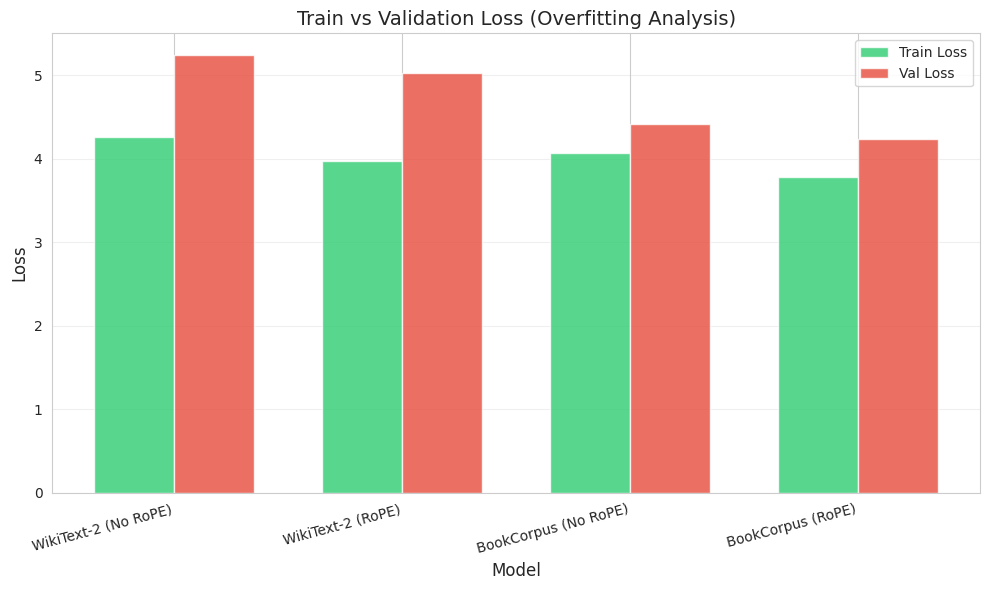


Figure saved: rope_comparison_overfitting.png


In [20]:
# Calculate train-val gap (overfitting indicator)
print("="*80)
print("OVERFITTING ANALYSIS (Train-Val Gap)")
print("="*80)
print(f"{'Model':<30} {'Train Loss':>12} {'Val Loss':>12} {'Gap':>12} {'Gap %':>12}")
print("-"*80)

gaps = {}
for model_name, res in results.items():
    gap = res['val_loss'] - res['train_loss']
    gap_pct = (res['val_loss'] - res['train_loss']) / res['train_loss'] * 100
    gaps[model_name] = {'gap': gap, 'gap_pct': gap_pct}
    print(f"{display_names[model_name]:<30} {res['train_loss']:>12.4f} {res['val_loss']:>12.4f} {gap:>12.4f} {gap_pct:>11.2f}%")

print("="*80)

# Compare RoPE effect on overfitting
print("\nRoPE Effect on Overfitting:")
wiki_gap_change = gaps['wikitext_rope']['gap_pct'] - gaps['wikitext_no_rope']['gap_pct']
book_gap_change = gaps['bookcorpus_rope']['gap_pct'] - gaps['bookcorpus_no_rope']['gap_pct']

print(f"  WikiText-2: Gap change with RoPE: {wiki_gap_change:+.2f}% (negative = less overfitting)")
print(f"  BookCorpus: Gap change with RoPE: {book_gap_change:+.2f}% (negative = less overfitting)")

# Plot overfitting comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results))
model_labels = [display_names[m] for m in results.keys()]
train_losses = [res['train_loss'] for res in results.values()]
val_losses = [res['val_loss'] for res in results.values()]

width = 0.35
ax.bar(x - width/2, train_losses, width, label='Train Loss', color='#2ecc71', alpha=0.8)
ax.bar(x + width/2, val_losses, width, label='Val Loss', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Train vs Validation Loss (Overfitting Analysis)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rope_comparison_overfitting.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: rope_comparison_overfitting.png")

## Summary and Interpretation

In [21]:
print("="*80)
print("FINAL SUMMARY: RoPE vs STANDARD POSITION EMBEDDINGS")
print("="*80)

# WikiText-2 Analysis
print("\n" + "-"*40)
print("WIKITEXT-2 (Encyclopedic Text)")
print("-"*40)
print(f"  Without RoPE:")
print(f"    - Validation Loss: {results['wikitext_no_rope']['val_loss']:.4f}")
print(f"    - Validation PPL:  {results['wikitext_no_rope']['val_ppl']:.2f}")
print(f"  With RoPE:")
print(f"    - Validation Loss: {results['wikitext_rope']['val_loss']:.4f}")
print(f"    - Validation PPL:  {results['wikitext_rope']['val_ppl']:.2f}")
print(f"  Improvement: {wiki_val_improvement:+.2f}%")

if wiki_val_improvement > 0:
    print(f"  - RoPE IMPROVES performance on WikiText-2")
elif wiki_val_improvement < 0:
    print(f"  - RoPE DEGRADES performance on WikiText-2")
else:
    print(f"  - No significant difference on WikiText-2")

# BookCorpus Analysis
print("\n" + "-"*40)
print("BOOKCORPUS (Narrative Text)")
print("-"*40)
print(f"  Without RoPE:")
print(f"    - Validation Loss: {results['bookcorpus_no_rope']['val_loss']:.4f}")
print(f"    - Validation PPL:  {results['bookcorpus_no_rope']['val_ppl']:.2f}")
print(f"  With RoPE:")
print(f"    - Validation Loss: {results['bookcorpus_rope']['val_loss']:.4f}")
print(f"    - Validation PPL:  {results['bookcorpus_rope']['val_ppl']:.2f}")
print(f"  Improvement: {book_val_improvement:+.2f}%")

if book_val_improvement > 0:
    print(f"  - RoPE IMPROVES performance on BookCorpus")
elif book_val_improvement < 0:
    print(f"  - RoPE DEGRADES performance on BookCorpus")
else:
    print(f"  - No significant difference on BookCorpus")

# Overall Analysis
print("\n" + "="*80)
print("OVERALL ANALYSIS")
print("="*80)

avg_improvement = (wiki_val_improvement + book_val_improvement) / 2
print(f"\nAverage RoPE improvement across datasets: {avg_improvement:+.2f}%")

# Effect consistency
effect_diff = abs(wiki_val_improvement - book_val_improvement)
print(f"\nEffect consistency:")
if effect_diff < 2:
    print(f"  - RoPE has CONSISTENT effect across text styles (diff: {effect_diff:.2f}%)")
elif effect_diff < 5:
    print(f"  - RoPE has MODERATELY DIFFERENT effect across text styles (diff: {effect_diff:.2f}%)")
else:
    print(f"  - RoPE has SIGNIFICANTLY DIFFERENT effect across text styles (diff: {effect_diff:.2f}%)")

# Conclusion
print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

if avg_improvement > 2:
    print("\n1. RoPE provides a measurable improvement over standard position embeddings.")
elif avg_improvement < -2:
    print("\n1. Standard position embeddings outperform RoPE in this configuration.")
else:
    print("\n1. RoPE and standard position embeddings perform similarly.")

if wiki_val_improvement > book_val_improvement:
    print("2. RoPE benefits encyclopedic text (WikiText-2) more than narrative text.")
elif book_val_improvement > wiki_val_improvement:
    print("2. RoPE benefits narrative text (BookCorpus) more than encyclopedic text.")
else:
    print("2. RoPE provides similar benefits across both text styles.")

# Overfitting conclusion
avg_gap_change = (wiki_gap_change + book_gap_change) / 2
if avg_gap_change < -1:
    print("3. RoPE helps reduce overfitting (smaller train-val gap).")
elif avg_gap_change > 1:
    print("3. RoPE slightly increases overfitting tendency.")
else:
    print("3. RoPE has minimal effect on overfitting.")

print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*80)

FINAL SUMMARY: RoPE vs STANDARD POSITION EMBEDDINGS

----------------------------------------
WIKITEXT-2 (Encyclopedic Text)
----------------------------------------
  Without RoPE:
    - Validation Loss: 5.2375
    - Validation PPL:  188.20
  With RoPE:
    - Validation Loss: 5.0195
    - Validation PPL:  151.34
  Improvement: +19.58%
  - RoPE IMPROVES performance on WikiText-2

----------------------------------------
BOOKCORPUS (Narrative Text)
----------------------------------------
  Without RoPE:
    - Validation Loss: 4.4143
    - Validation PPL:  82.62
  With RoPE:
    - Validation Loss: 4.2381
    - Validation PPL:  69.28
  Improvement: +16.15%
  - RoPE IMPROVES performance on BookCorpus

OVERALL ANALYSIS

Average RoPE improvement across datasets: +17.87%

Effect consistency:
  - RoPE has MODERATELY DIFFERENT effect across text styles (diff: 3.43%)

CONCLUSIONS

1. RoPE provides a measurable improvement over standard position embeddings.
2. RoPE benefits encyclopedic text (Wi

## Save Results Report

In [22]:
# Save comprehensive results to file
report = []
report.append("="*80)
report.append("RoPE vs Standard Position Embeddings - Comparison Report")
report.append("="*80)
report.append(f"\nExperiment Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")
report.append(f"Total Training Time: {total_training_time/3600:.2f} hours")
report.append("\n" + "="*80)
report.append("MODEL CONFIGURATION")
report.append("="*80)
report.append(f"  Layers: {n_layer}")
report.append(f"  Heads: {n_head}")
report.append(f"  Embedding dim: {n_embd}")
report.append(f"  Block size: {block_size}")
report.append(f"  Parameters: {num_params/1e6:.2f}M")
report.append(f"  RoPE theta: {rope_theta}")
report.append("\n" + "="*80)
report.append("TRAINING CONFIGURATION")
report.append("="*80)
report.append(f"  Max iterations: {max_iters}")
report.append(f"  Batch size: {batch_size}")
report.append(f"  Learning rate: {learning_rate}")
report.append(f"  Weight decay: {weight_decay}")
report.append(f"  Dropout: {dropout}")
report.append("\n" + "="*80)
report.append("FINAL RESULTS")
report.append("="*80)
report.append(f"{'Model':<30} {'Val Loss':>12} {'Val PPL':>12}")
report.append("-"*60)
for model_name, res in results.items():
    report.append(f"{display_names[model_name]:<30} {res['val_loss']:>12.4f} {res['val_ppl']:>12.2f}")
report.append("\n" + "="*80)
report.append("ROPE IMPROVEMENT")
report.append("="*80)
report.append(f"  WikiText-2: {wiki_val_improvement:+.2f}%")
report.append(f"  BookCorpus: {book_val_improvement:+.2f}%")
report.append(f"  Average: {avg_improvement:+.2f}%")
report.append("\n" + "="*80)

# Write report
report_text = "\n".join(report)
with open('rope_comparison_summary.txt', 'w') as f:
    f.write(report_text)

print(report_text)
print("\nReport saved to: rope_comparison_summary.txt")

RoPE vs Standard Position Embeddings - Comparison Report

Experiment Date: 2026-01-04 18:50:04
Total Training Time: 1.26 hours

MODEL CONFIGURATION
  Layers: 6
  Heads: 6
  Embedding dim: 384
  Block size: 256
  Parameters: 29.95M
  RoPE theta: 10000.0

TRAINING CONFIGURATION
  Max iterations: 3000
  Batch size: 12
  Learning rate: 0.001
  Weight decay: 0.1
  Dropout: 0.1

FINAL RESULTS
Model                              Val Loss      Val PPL
------------------------------------------------------------
WikiText-2 (No RoPE)                 5.2375       188.20
WikiText-2 (RoPE)                    5.0195       151.34
BookCorpus (No RoPE)                 4.4143        82.62
BookCorpus (RoPE)                    4.2381        69.28

ROPE IMPROVEMENT
  WikiText-2: +19.58%
  BookCorpus: +16.15%
  Average: +17.87%


Report saved to: rope_comparison_summary.txt
